In [1]:
#pip install shap

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import shap 

df = pd.read_csv('genderIndicators_worldBank_highinc.csv')

In [3]:
df = df.dropna(subset=['SH.STA.MMRT'])
df

,Country,Year,IC.FRM.FEMM.ZS,IC.FRM.FEMO.ZS,SE.ADT.1524.LT.FE.ZS,SE.ADT.1524.LT.FM.ZS,SE.ADT.1524.LT.MA.ZS,SE.ADT.LITR.FE.ZS,SE.ADT.LITR.MA.ZS,SE.ENR.PRIM.FM.ZS,...,SP.POP.AG03.FE.IN,SP.POP.AG03.MA.IN,SP.POP.AG04.FE.IN,SP.POP.AG04.MA.IN,SP.POP.AG05.FE.IN,SP.POP.AG05.MA.IN,SP.RUR.TOTL.FE.ZS,SP.RUR.TOTL.MA.ZS,SP.URB.TOTL.FE.ZS,SP.URB.TOTL.MA.ZS
198,ARE,2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,25227.0,26903.0,23592.5,25433.0,22437.5,24447.0,6.642432,13.11963,25.842697,54.395241
199,ARE,2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,25867.0,27547.5,25282.0,27094.5,23862.5,25869.0,NaN,NaN,NaN,NaN
200,ARE,2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26430.5,28097.5,25877.5,27662.5,25338.0,27289.0,NaN,NaN,NaN,NaN
201,ARE,2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26913.0,28568.5,26394.5,28140.5,25888.5,27780.0,NaN,NaN,NaN,NaN
202,ARE,2004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27309.5,28960.0,26828.5,28543.5,26359.5,28185.5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6297,USA,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.99833,...,1969807.0,2062236.5,1980703.5,2075242.0,1994372.0,2093948.5,NaN,NaN,NaN,NaN
6298,USA,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.99234,...,1978766.0,2071786.0,1981373.5,2074372.5,1991103.5,2086558.0,NaN,NaN,NaN,NaN
6299,USA,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.99884,...,1990342.5,2080863.0,1991357.0,2084866.5,1991857.0,2085390.0,NaN,NaN,NaN,NaN
6300,USA,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00705,...,1982090.0,2074245.0,2004235.0,2094980.0,2003251.5,2097239.5,NaN,NaN,NaN,NaN


## Simple Linear Regression

In [4]:
# First need to encode the country 

# Create a LabelEncoder instance for each categorical column
country_encoder = LabelEncoder()

# Encode the categorical columns
data_encoded = df.copy(deep = True)
data_encoded['Country'] = country_encoder.fit_transform(data_encoded['Country'])

In [5]:
# Replace nans with 0
data_encoded.fillna(0, inplace=True)
data_encoded

,Country,Year,IC.FRM.FEMM.ZS,IC.FRM.FEMO.ZS,SE.ADT.1524.LT.FE.ZS,SE.ADT.1524.LT.FM.ZS,SE.ADT.1524.LT.MA.ZS,SE.ADT.LITR.FE.ZS,SE.ADT.LITR.MA.ZS,SE.ENR.PRIM.FM.ZS,...,SP.POP.AG03.FE.IN,SP.POP.AG03.MA.IN,SP.POP.AG04.FE.IN,SP.POP.AG04.MA.IN,SP.POP.AG05.FE.IN,SP.POP.AG05.MA.IN,SP.RUR.TOTL.FE.ZS,SP.RUR.TOTL.MA.ZS,SP.URB.TOTL.FE.ZS,SP.URB.TOTL.MA.ZS
198,0,2000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,25227.0,26903.0,23592.5,25433.0,22437.5,24447.0,6.642432,13.11963,25.842697,54.395241
199,0,2001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,25867.0,27547.5,25282.0,27094.5,23862.5,25869.0,0.000000,0.00000,0.000000,0.000000
200,0,2002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,26430.5,28097.5,25877.5,27662.5,25338.0,27289.0,0.000000,0.00000,0.000000,0.000000
201,0,2003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,26913.0,28568.5,26394.5,28140.5,25888.5,27780.0,0.000000,0.00000,0.000000,0.000000
202,0,2004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,27309.5,28960.0,26828.5,28543.5,26359.5,28185.5,0.000000,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6297,54,2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.99833,...,1969807.0,2062236.5,1980703.5,2075242.0,1994372.0,2093948.5,0.000000,0.00000,0.000000,0.000000
6298,54,2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.99234,...,1978766.0,2071786.0,1981373.5,2074372.5,1991103.5,2086558.0,0.000000,0.00000,0.000000,0.000000
6299,54,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.99884,...,1990342.5,2080863.0,1991357.0,2084866.5,1991857.0,2085390.0,0.000000,0.00000,0.000000,0.000000
6300,54,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00705,...,1982090.0,2074245.0,2004235.0,2094980.0,2003251.5,2097239.5,0.000000,0.00000,0.000000,0.000000


In [6]:
# pull out Maternal Mortality as the predictor variable 
X = data_encoded.drop(columns='SH.STA.MMRT')
y = data_encoded['SH.STA.MMRT']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 7.144555786132069
R-squared: 0.9896908637663677


In [9]:
def plot_linear_reg(X, y, yp, country, title):

 # X - X_test
 # y - y_test
 # yp - y_pred
 # country - list of country abbreviations ie. ['USA']

    if country == None: 

        # Plot the data points and the regression line
        plt.figure(figsize=(30, 20))
        plt.scatter(X['Year'], y, color='blue', label='Data')
        plt.scatter(X['Year'], yp, color='red',  label='Linear Regression')
        plt.xlabel('Year')
        plt.ylabel('Maternal Mortality Ratio')
        plt.title(title)
        plt.legend()
        plt.figure(figsize=(30, 20))
        plt.show()
        
    else: 
        # Country encoding 
        encoded_values = country_encoder.transform(country)
        # looking at just the secific country predictions in test partition

        # Use boolean indexing to select the subset of the DataFrame
        condition = X['Country'].isin(encoded_values)
        X_test = X[condition]['Year']
        y_test = y.loc[X_test.index]

        # take the array index in order to pull the relevant y_pred  
        index_positions = [y.index.get_loc(index) for index in X_test.index]
        
        y_pred = [yp[i] for i in index_positions]
        
        # Plot the data points and the regression line
        plt.figure(figsize=(15, 10))
        plt.scatter(X_test, y_test, color='blue', label='Data')
        plt.scatter(X_test, y_pred, color='red',  label='Linear Regression')
        plt.xlabel('Year')
        plt.ylabel('Maternal Mortality Ratio')
        plt.title(title)
        plt.legend()
        plt.show()

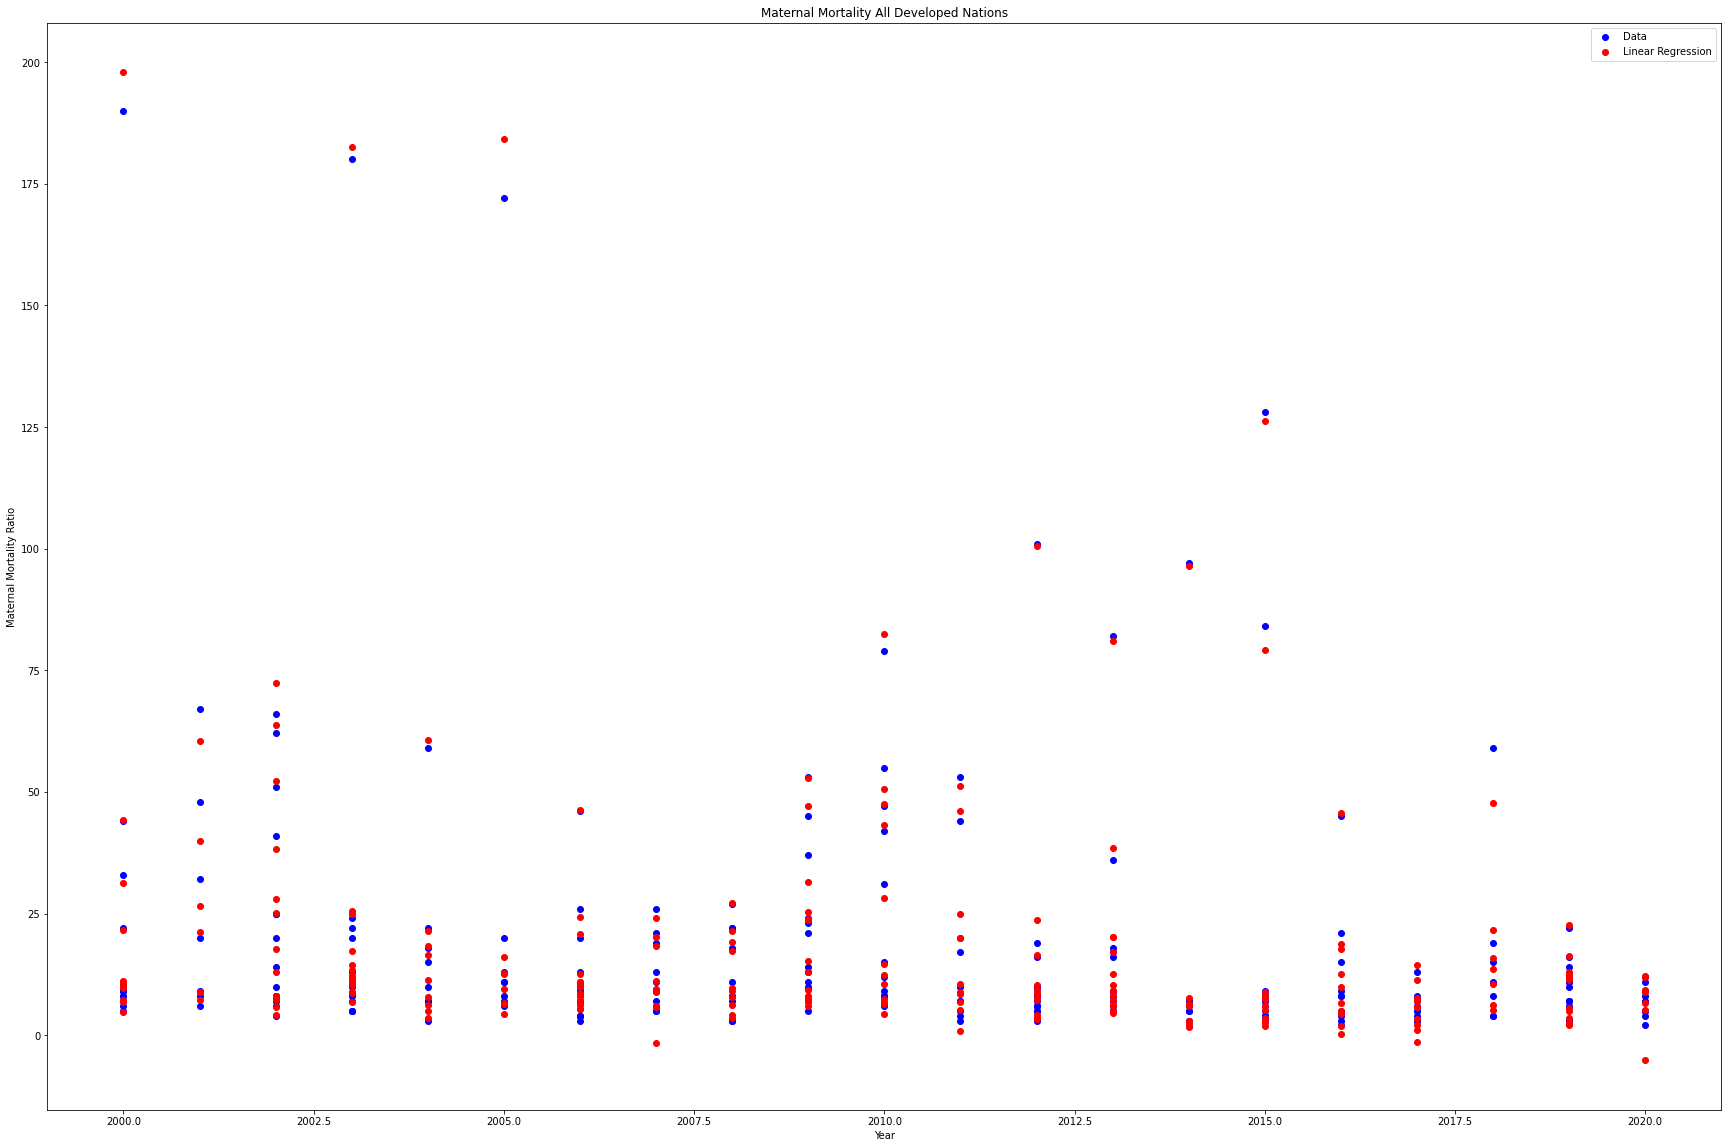

<Figure size 2160x1440 with 0 Axes>

In [10]:
plot_linear_reg(X_test, y_test, y_pred, country = None, title = 'Maternal Mortality All Developed Nations')

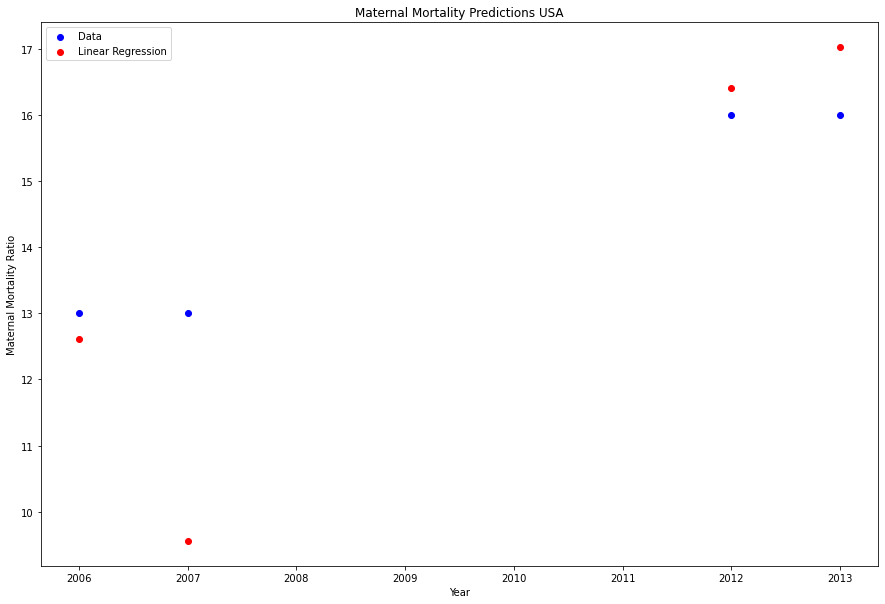

In [11]:
plot_linear_reg(X_test, y_test, y_pred, country = ['USA'], title = 'Maternal Mortality Predictions USA')

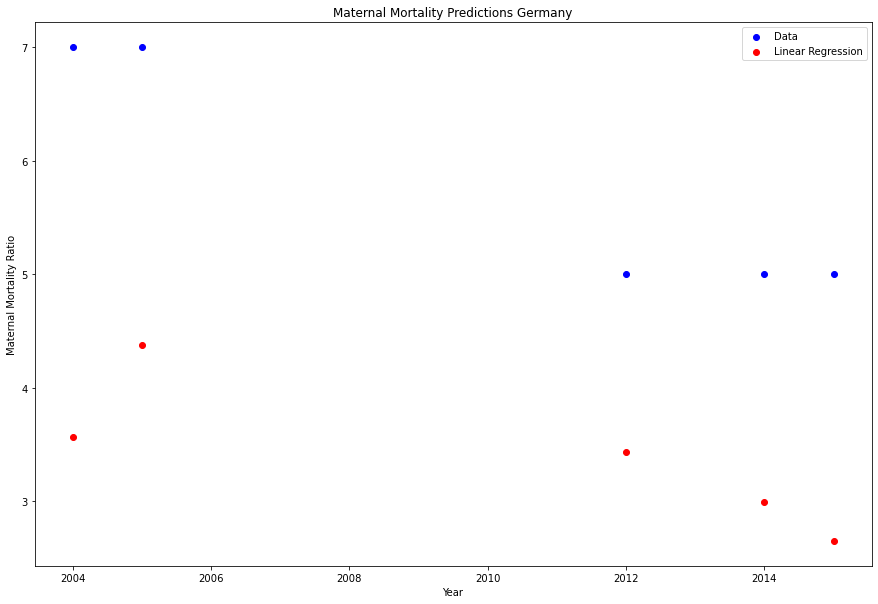

In [12]:
plot_linear_reg(X_test, y_test, y_pred, country = ['DEU'], title = 'Maternal Mortality Predictions Germany')

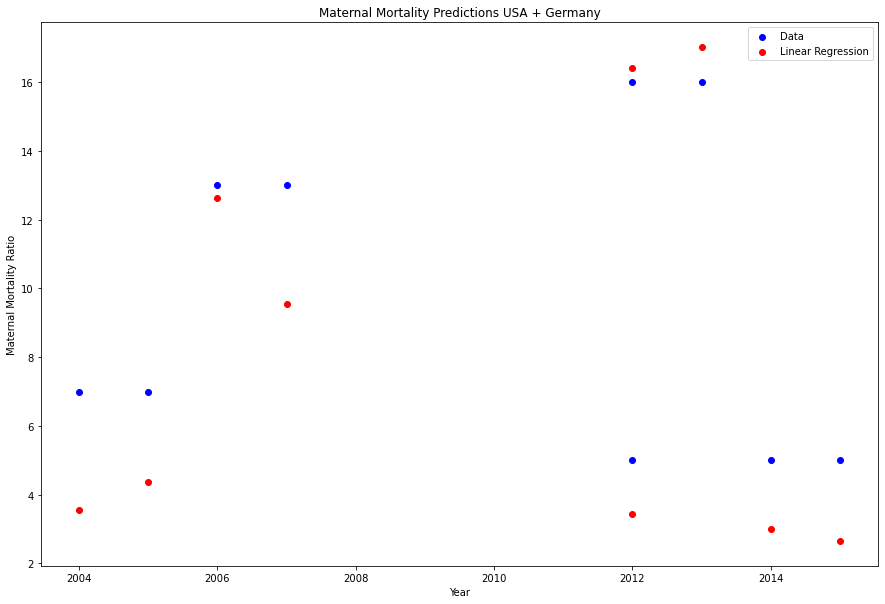

In [13]:
plot_linear_reg(X_test, y_test, y_pred, country = ['DEU', 'USA'], title = 'Maternal Mortality Predictions USA + Germany')

## Shapley Values

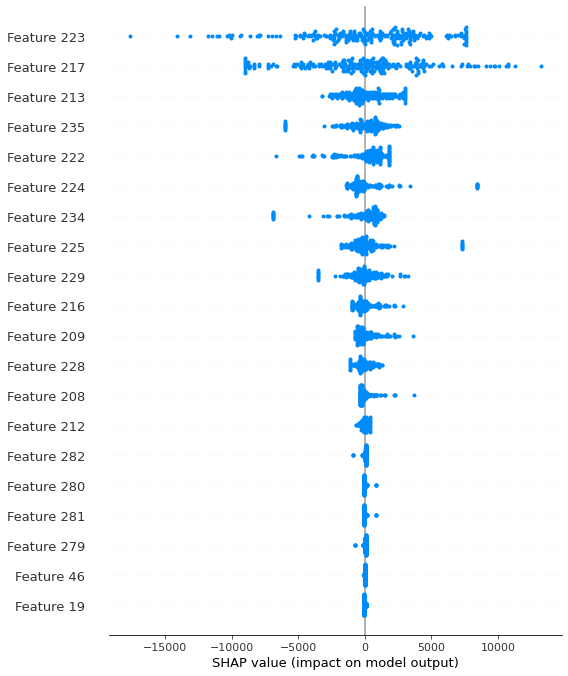

In [14]:
explainer = shap.LinearExplainer(model, X_train)

# look at the features for all instances
shap_values = explainer.shap_values(X_test) 

shap.summary_plot(shap_values)

#shap_values.shape

In [15]:
print(f'These are the top features: {X_train.columns[223]}, {X_train.columns[217]}, {X_train.columns[213]}, {X_train.columns[235]}')
      

These are the top features: SL.EMP.VULN.MA.ZS, SL.EMP.SELF.MA.ZS, SL.EMP.MPYR.MA.ZS, SL.SRV.EMPL.MA.ZS


SL.EMP.VULN.MA.ZS: Vulnerable employment, male (% of male employment) (modeled ILO estimate)   
SL.EMP.SELF.MA.ZS: 	Self-employed, male (% of male employment) (modeled ILO estimate)   
SL.EMP.MPYR.MA.ZS:	Employers, male (% of male employment) (modeled ILO estimate)   
SL.SRV.EMPL.MA.ZS: 	Employment in services, male (% of male employment) (modeled ILO estimate)   

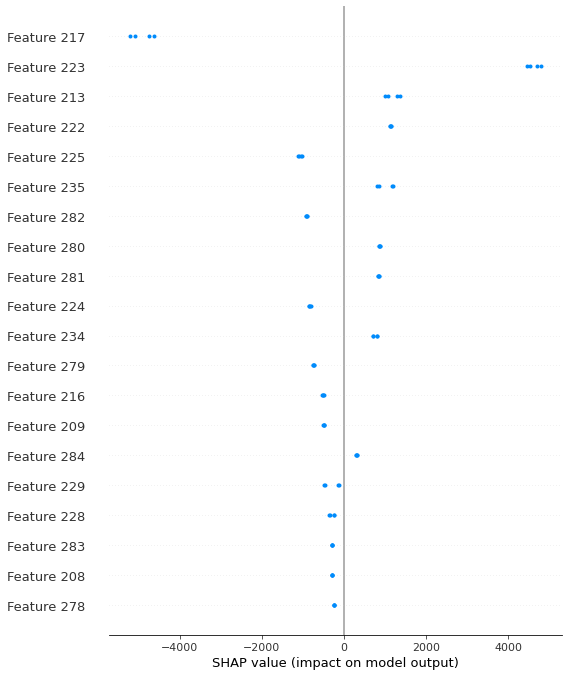

In [16]:
# look at the features for the USA predictions 
encoded_values = country_encoder.transform(['USA'])

condition = X_test['Country'].isin(encoded_values)
X_country_lens = X_test[condition]['Year']

shap_values = explainer.shap_values(X_test.loc[X_country_lens.index]) 
shap.summary_plot(shap_values)